In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import digamma
from sklearn.gaussian_process import GaussianProcessRegressor


import warnings

# Ignore all warnings
# warnings.filterwarnings("ignore")

In [2]:
# !pip install torch==2.0.0
# !pip install gpytorch==1.11

In [3]:
import gpytorch
gpytorch.__version__

/Users/menang/anaconda3/envs/py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.11'

In [4]:
import torch
torch.__version__

'2.0.0'

In [5]:
torch.manual_seed(0)
np.random.seed(0)

A simple simulation experimental setup:
$$f(x)=x\log x,\;x\in[0,1],\;X|Y=y \sim \textrm{Beta}(\alpha(y),\beta(y)).$$
$f$ has a minimum at $x=1/e$ (no local minima). We can compute
$$g(y)=\mathbb E_{X|Y=y}\left[X\log X\right]=\frac{\alpha(y)}{\alpha(y)+\beta(y)}\left[\psi(\alpha(y)+1)-\psi(\alpha(y)+\beta(y)+1)\right],$$
where $\psi$ is the digamma function. To complete the setup need to choose some functions $\alpha:\mathcal Y\to (0,+\infty)$, $\beta:\mathcal Y\to (0,+\infty),$ e.g. take $\mathcal Y=\mathbb R^3$ and
$$\alpha(y)=\exp(a^\top y+c),\;\beta(y)=\exp(b^\top y+d),$$
or similar.

Nb. the bounded domain of $X$ might need to be built into the kernel construction when estimating CME $X|Y$, e.g. one can use
$$k(x,x')=\exp\left(-\frac{1}{2\gamma^2}\left(\log\frac{x}{1-x}-\log\frac{x'}{1-x'}\right)^2\right),\quad x,x'\in(0,1).$$


In [6]:
def alpha(y,a=1,c=0):
    return np.exp(a * y +c)

def beta(y, b=1, d=0):
    return np.exp(b* y + d)

def func(x):
    return -x * np.log(x)

def g(y,a=1,b=0,c=1,d=0):
    alpha_value = alpha(y,a,c)
    beta_value = beta(y,b,d)
    g_value = alpha_value/(alpha_value+beta_value) * (digamma(alpha_value + 1) - digamma(alpha_value + beta_value + 1))
    return -g_value

In [7]:
def generate_D1(n, a,b,c,d, l, u):
    ys = np.random.uniform(l,u,n)
    alphas = []
    betas = []
    xs = []
    fs = []
    for i in ys:
        alpha_value = alpha(i,a,c)
        alphas.append(alpha_value)
        
        beta_value = beta(i,b,d)
        betas.append(beta_value)
        x_value = np.random.beta(alpha_value, beta_value)
        xs.append(x_value)
    plt.plot(ys, xs, '.')
    plt.xlabel('y')
    plt.ylabel('x')
    plt.title('D1')
    
    plt.legend()
    return np.asarray(xs), np.asarray(ys)
    

def generate_D2(m, a,b,c,d, l, u, sigma=0.01, plot=True):
    ys = np.random.uniform(l,u,m)
    zs = []
    
    alphas = []
    betas = []
    xs = []
    fs = []
    for y in ys:
        alpha_value = alpha(y,a,c)
        alphas.append(alpha_value)
        
        beta_value = beta(y,b,d)
        betas.append(beta_value)
        x_value = np.random.beta(alpha_value, beta_value)
        xs.append(x_value)
        fs.append(func(x_value))  
        
        g_value = g(y, a,b,c,d)
        z_value = g_value + np.random.normal(0, sigma)
        zs.append(z_value)
        
    if plot:    
        # plt.plot(ys, xs, '.', label = 'x')
        # plt.plot(fs, xs, '.', label = 'f(x)')
        
        plt.plot(ys, zs,'.')
        plt.xlabel('y')
        plt.ylabel('z (aggregated feedback)')
        plt.title('D2')
        
    return np.asarray(ys), np.asarray(zs)

In [8]:
a = 0.1
b = 4
c = 2
d = 0
sigma = 0.01

l = 1e-5
u = 1- 1e-5

In [9]:
# a = 1
# b = 4
# c = 0
# d = 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


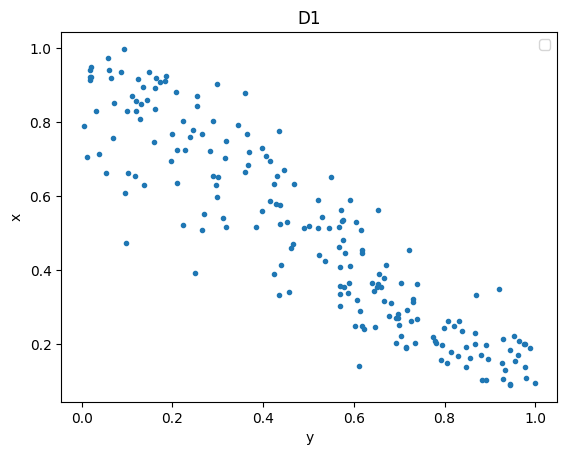

In [10]:
xs, ys = generate_D1(200,a,b,c,d, l, u)

Text(0, 0.5, 'f(x)')

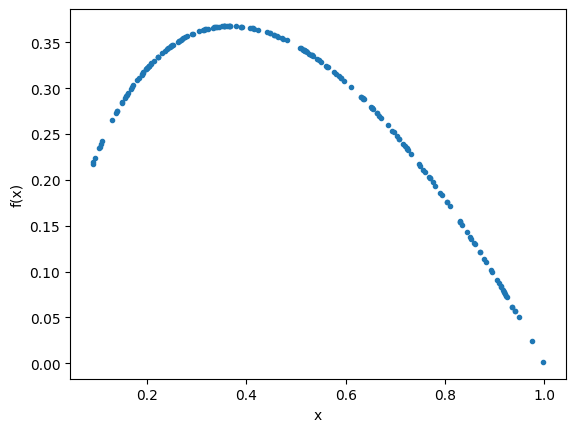

In [11]:
plt.plot(xs, func(xs), '.')
plt.xlabel('x')
plt.ylabel('f(x)')

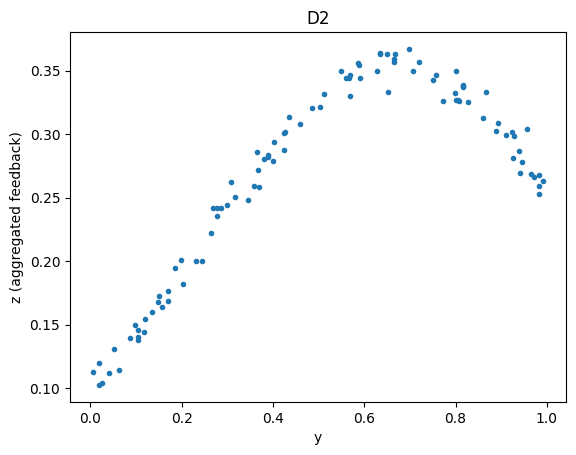

In [12]:
ys2, zs = generate_D2(100, a,b,c,d, l, u, sigma)

In [13]:
# data_set = {}
# data_set['x'] = xs
# data_set['y'] = ys
# data_set['z'] = zs
# data_set['y2'] = ys2
# np.save('data_set.npy', data_set)

data_set = np.load('data_set.npy', allow_pickle=True).item()
xs = data_set['x']
ys = data_set['y']
zs = data_set['z']
ys2 = data_set['y2']

In [14]:
muz, sigmaz = zs.mean(), zs.std()
# muz, sigmaz = 0,1
print(zs.mean(), zs.std())
zs = (zs - muz) / sigmaz

0.26818679742323204 0.07682413535809043


In [15]:
import sys
# sys.path.append("../deconditional-downscaling/")
sys.path.append("experiments/swiss_roll/")
from models import build_model, train_model, predict 
import yaml 
import torch

cdf_dir = 'experiments/swiss_roll/config/exact_cmp.yaml' 
# cdf_dir = 'exact_cmp.yaml' 

with open(cdf_dir, "r") as f:
    cfg = yaml.safe_load(f)

cfg['model'].update(individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys))
model = build_model(cfg['model'])

In [16]:
groundtruth_individuals = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float()

cfg['training'].update(model=model,
                    individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys),
                    groundtruth_individuals=groundtruth_individuals,
                    groundtruth_bags_sizes=len(groundtruth_individuals),
                    groundtruth_targets=func(groundtruth_individuals).float(),
                    chunk_size=cfg['evaluation']['chunk_size_nll'],
                    device_idx='cpu',
                    dump_dir='result/'
                    )
train_model(cfg['training'])

/Users/menang/anaconda3/envs/py3.9/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/menang/anaconda3/envs/py3.9/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/menang/anaconda3/envs/py3.9/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


In [17]:
predict_kwargs = {'name': cfg['model']['name'],
                'model': model.eval().cpu(),
                'individuals': groundtruth_individuals,
                'bags_sizes': func(groundtruth_individuals)}
individuals_posterior = predict(predict_kwargs)
individuals_posterior_mean = sigmaz * individuals_posterior.mean + muz
with torch.no_grad():
    stddev = sigmaz * individuals_posterior.stddev
    lower_bound = individuals_posterior_mean - 2 * stddev
    upper_bound = individuals_posterior_mean + 2 * stddev

In [18]:
individuals_posterior.sample()

tensor([-2.5085e+00, -2.7223e+00, -2.9019e+00, -3.0441e+00, -3.1286e+00,
        -3.1512e+00, -3.1165e+00, -3.0341e+00, -2.8852e+00, -2.6998e+00,
        -2.4661e+00, -2.1958e+00, -1.8992e+00, -1.5728e+00, -1.2234e+00,
        -8.6007e-01, -4.9406e-01, -1.2816e-01,  2.3417e-01,  5.8495e-01,
         9.1275e-01,  1.2040e+00,  1.4660e+00,  1.7039e+00,  1.9022e+00,
         2.0606e+00,  2.1898e+00,  2.2860e+00,  2.3666e+00,  2.4312e+00,
         2.4844e+00,  2.5187e+00,  2.5429e+00,  2.5575e+00,  2.5525e+00,
         2.5302e+00,  2.4846e+00,  2.4107e+00,  2.3132e+00,  2.1865e+00,
         2.0314e+00,  1.8613e+00,  1.6694e+00,  1.4710e+00,  1.2729e+00,
         1.0930e+00,  9.0710e-01,  7.3510e-01,  5.7844e-01,  4.3989e-01,
         3.1733e-01,  2.0441e-01,  1.0166e-01,  4.9344e-03, -7.8211e-02,
        -1.5815e-01, -2.3296e-01, -2.9246e-01, -3.3410e-01, -3.4185e-01,
        -3.5133e-01, -3.3401e-01, -2.8106e-01, -2.2373e-01, -1.5668e-01,
        -7.7247e-02, -1.6240e-03,  6.6865e-02,  9.9

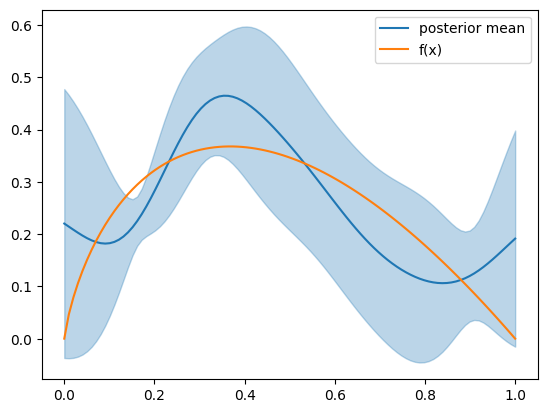

In [19]:
plt.plot(groundtruth_individuals, individuals_posterior_mean, label = 'posterior mean', color='C0')
plt.fill_between(groundtruth_individuals, lower_bound, upper_bound, alpha=0.3, color='C0')
# plt.plot(groundtruth_individuals, (conf[1]-conf[0]).detach().numpy(), label = '2 * posterior std')
plt.plot(groundtruth_individuals, func(groundtruth_individuals), label = 'f(x)', color='C1')
# plt.plot(xs, f(xs), '.', label = 'data points')
plt.legend()

In [21]:
from BO import BayesOpt_UCB, BayesOpt_Random, PES, MES

# a = 0.1
# b = 4
# c = 2
# d = 0
# sigma = 0.01

def g_oracle(y, a=0.1,b=4,c=2,d=0, sigma=0.01):
    g_value = g(y, a,b,c,d)
    z_value = g_value + np.random.normal(0, sigma)
    return z_value

x_space = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float() # np.linspace(1e-5,1-1e-5,100)
y_space = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float() # np.linspace(1e-5,1-1e-5,100)
init_y_size = 15
num_round = 30
num_repeat = 10
random_seeds = np.random.uniform(0,100, num_repeat)

pos_best_dict = {}
z_rewards_dict = {}

xs = torch.from_numpy(xs).float()
ys = torch.from_numpy(ys).float()

In [22]:
model.eval()
# bag_to_predict = torch.tensor(ys2).float()
bag_to_predict = y_space

with torch.no_grad():
    # https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html
    bag_posterior = model.likelihood(model(bag_to_predict)) # posterior with noise
    # bag_posterior = model(y_space) # posterior without noise
    bag_posterior_mean = sigmaz * bag_posterior.mean + muz
    stddev = sigmaz * bag_posterior.stddev
    lower_bound = bag_posterior_mean - 2 * stddev
    upper_bound = bag_posterior_mean + 2 * stddev

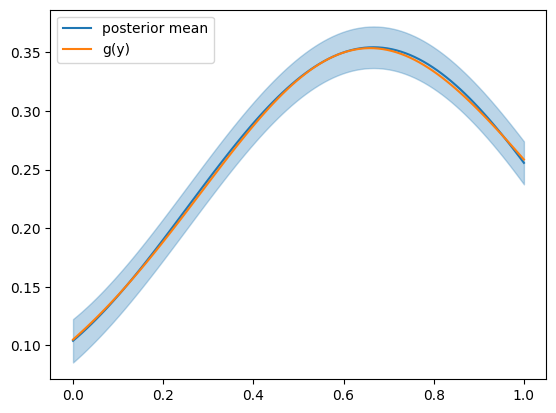

In [23]:
plt.plot(bag_to_predict,bag_posterior_mean, label = 'posterior mean', color='C0')
plt.fill_between(bag_to_predict, lower_bound, upper_bound, alpha=0.3, color='C0')
# plt.plot(groundtruth_individuals, (conf[1]-conf[0]).detach().numpy(), label = '2 * posterior std')
plt.plot(bag_to_predict, g(bag_to_predict,a,b,c,d), label = 'g(y)', color='C1')
# plt.plot(xs, f(xs), '.', label = 'data points')
plt.legend()

In [40]:
groundtruth_individuals[np.argmin(func(groundtruth_individuals))]

tensor(1.0000)

In [21]:
groundtruth_individuals[np.argmin(individuals_posterior_mean)]

tensor(0.8384)

In [23]:
# agent_ucb = BayesOpt_UCB(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp.yaml', dump_dir='result/ucb/', random_seeds=random_seeds)
# pos_best_dict['ucb'] = agent_ucb.simulation()

In [24]:
# num_repeat = 1
agent_mes = MES(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp.yaml', dump_dir='result/mes/', random_seeds=random_seeds, maximize=True)
pos_best_mes, z_rewards_mes = agent_mes.simulation()
pos_best_dict['mes'] = pos_best_mes
z_rewards_dict['mes'] = z_rewards_mes

  0%|          | 0/10 [00:00<?, ?it/s]

[2.1212697e-01 5.3535283e-01 8.8888109e-01 8.1817544e-01 3.6363909e-01
 6.1615932e-01 2.7273181e-01 6.0605848e-01 6.5656251e-01 2.3232858e-01
 6.4646173e-01 6.7676413e-01 3.0303425e-01 9.9999997e-06 1.0110809e-02]


Iteration 1: Elapsed Time: 3.5796959400177 seconds


Iteration 2: Elapsed Time: 3.253321886062622 seconds


Iteration 3: Elapsed Time: 3.404655933380127 seconds


Iteration 4: Elapsed Time: 3.265162944793701 seconds


Iteration 5: Elapsed Time: 3.407806873321533 seconds


Iteration 6: Elapsed Time: 3.4675300121307373 seconds


Iteration 7: Elapsed Time: 3.388360023498535 seconds


Iteration 8: Elapsed Time: 3.2719039916992188 seconds


Iteration 9: Elapsed Time: 3.244870185852051 seconds


Iteration 10: Elapsed Time: 3.3581931591033936 seconds


Iteration 11: Elapsed Time: 3.2303600311279297 seconds


Iteration 12: Elapsed Time: 3.4864370822906494 seconds


Iteration 13: Elapsed Time: 3.333538055419922 seconds


Iteration 14: Elapsed Time: 3.1737730503082275 seconds


 10%|█         | 1/10 [00:50<07:31, 50.20s/it]

Iteration 15: Elapsed Time: 3.3178482055664062 seconds
[0.45454636 0.08081646 0.55555445 0.70706654 0.58585685 0.737369
 0.43434474 0.32323587 0.6565625  0.4949496  0.5050504  0.787873
 0.05051404 0.5353528  0.8484779 ]


Iteration 1: Elapsed Time: 3.2341561317443848 seconds


Iteration 2: Elapsed Time: 3.2736330032348633 seconds


Iteration 3: Elapsed Time: 3.2818450927734375 seconds


Iteration 4: Elapsed Time: 3.2020459175109863 seconds


Iteration 5: Elapsed Time: 3.4024369716644287 seconds


Iteration 6: Elapsed Time: 3.515136957168579 seconds


Iteration 7: Elapsed Time: 3.280506134033203 seconds


Iteration 8: Elapsed Time: 3.2524468898773193 seconds


Iteration 9: Elapsed Time: 3.3744757175445557 seconds


Iteration 10: Elapsed Time: 3.5637099742889404 seconds


Iteration 11: Elapsed Time: 3.423586130142212 seconds


Iteration 12: Elapsed Time: 3.6201701164245605 seconds


Iteration 13: Elapsed Time: 3.1455390453338623 seconds


Iteration 14: Elapsed Time: 3.369497060775757 seconds


 20%|██        | 2/10 [01:40<06:42, 50.33s/it]

Iteration 15: Elapsed Time: 3.464805841445923 seconds
[0.5757561  0.7171674  0.99999    0.5959577  0.6565625  0.7575706
 0.24242939 0.23232858 0.6060585  0.80807465 0.787873   0.12121969
 0.3838407  0.18182455 0.11111889]


Iteration 1: Elapsed Time: 3.3198890686035156 seconds


Iteration 2: Elapsed Time: 3.224316358566284 seconds


Iteration 3: Elapsed Time: 3.379595994949341 seconds


Iteration 4: Elapsed Time: 3.2726547718048096 seconds


Iteration 5: Elapsed Time: 3.407417058944702 seconds


Iteration 6: Elapsed Time: 3.3559188842773438 seconds


Iteration 7: Elapsed Time: 3.314152956008911 seconds


Iteration 8: Elapsed Time: 3.3478808403015137 seconds


Iteration 9: Elapsed Time: 3.379361867904663 seconds


Iteration 10: Elapsed Time: 3.230151891708374 seconds


Iteration 11: Elapsed Time: 3.2282092571258545 seconds


Iteration 12: Elapsed Time: 3.434589147567749 seconds


Iteration 13: Elapsed Time: 3.354649066925049 seconds


Iteration 14: Elapsed Time: 3.284665107727051 seconds


 30%|███       | 3/10 [02:30<05:50, 50.14s/it]

Iteration 15: Elapsed Time: 3.3585808277130127 seconds
[0.09091727 0.2727318  0.18182455 0.3838407  0.8989819  0.30303425
 0.6363609  0.03031242 0.92928433 0.04041323 0.12121969 0.41414315
 0.6565625  0.42424393 0.07071566]


Iteration 1: Elapsed Time: 3.4001216888427734 seconds


Iteration 2: Elapsed Time: 3.314368963241577 seconds


Iteration 3: Elapsed Time: 3.3728389739990234 seconds


Iteration 4: Elapsed Time: 3.3350212574005127 seconds


Iteration 5: Elapsed Time: 3.335070848464966 seconds


Iteration 6: Elapsed Time: 3.3472776412963867 seconds


Iteration 7: Elapsed Time: 3.220257043838501 seconds


Iteration 8: Elapsed Time: 3.186208963394165 seconds


Iteration 9: Elapsed Time: 3.380659818649292 seconds


Iteration 10: Elapsed Time: 3.280696153640747 seconds


Iteration 11: Elapsed Time: 3.333113193511963 seconds


Iteration 12: Elapsed Time: 3.267078161239624 seconds


Iteration 13: Elapsed Time: 3.21173095703125 seconds


Iteration 14: Elapsed Time: 3.241753101348877 seconds


 40%|████      | 4/10 [03:20<04:59, 49.88s/it]

Iteration 15: Elapsed Time: 3.2475528717041016 seconds
[0.14142132 0.95958674 0.16162293 0.69696575 0.7676714  0.91918355
 0.22222778 0.28283262 0.81817544 0.5959577  0.97978836 0.5353528
 0.262631   0.2727318  0.18182455]


Iteration 1: Elapsed Time: 3.294132947921753 seconds


Iteration 2: Elapsed Time: 3.3722829818725586 seconds


Iteration 3: Elapsed Time: 3.341765880584717 seconds


Iteration 4: Elapsed Time: 3.296985149383545 seconds


Iteration 5: Elapsed Time: 3.333759069442749 seconds


Iteration 6: Elapsed Time: 3.332418918609619 seconds


Iteration 7: Elapsed Time: 3.3413619995117188 seconds


Iteration 8: Elapsed Time: 3.3450632095336914 seconds


Iteration 9: Elapsed Time: 3.4006922245025635 seconds


Iteration 10: Elapsed Time: 3.4123730659484863 seconds


Iteration 11: Elapsed Time: 3.213754177093506 seconds


Iteration 12: Elapsed Time: 3.4062421321868896 seconds


Iteration 13: Elapsed Time: 3.289764165878296 seconds


Iteration 14: Elapsed Time: 3.258018732070923 seconds


 50%|█████     | 5/10 [04:10<04:09, 49.95s/it]

Iteration 15: Elapsed Time: 3.41054105758667 seconds
[0.52525204 0.66666335 0.69696575 0.8989819  0.14142132 0.22222778
 0.4848488  0.28283262 0.3737399  0.03031242 0.72726816 0.01011081
 0.12121969 0.20202616 0.99999   ]


Iteration 1: Elapsed Time: 3.348845958709717 seconds


Iteration 2: Elapsed Time: 3.343809127807617 seconds


Iteration 3: Elapsed Time: 3.459773302078247 seconds


Iteration 4: Elapsed Time: 3.193819284439087 seconds


Iteration 5: Elapsed Time: 3.2712512016296387 seconds


Iteration 6: Elapsed Time: 3.2891318798065186 seconds


Iteration 7: Elapsed Time: 3.297212839126587 seconds


Iteration 8: Elapsed Time: 3.212355136871338 seconds


Iteration 9: Elapsed Time: 3.348068952560425 seconds


Iteration 10: Elapsed Time: 3.2786238193511963 seconds


Iteration 11: Elapsed Time: 3.4146180152893066 seconds


Iteration 12: Elapsed Time: 3.378701686859131 seconds


Iteration 13: Elapsed Time: 3.371791124343872 seconds


Iteration 14: Elapsed Time: 3.3827173709869385 seconds


 60%|██████    | 6/10 [05:00<03:19, 49.96s/it]

Iteration 15: Elapsed Time: 3.362069845199585 seconds
[0.6363609  0.72726816 0.92928433 0.45454636 0.14142132 0.11111889
 0.18182455 0.22222778 0.5050504  0.15152211 0.20202616 0.7474698
 0.04041323 0.7979738  0.70706654]


Iteration 1: Elapsed Time: 3.215294122695923 seconds


Iteration 2: Elapsed Time: 3.4126269817352295 seconds


Iteration 3: Elapsed Time: 3.3222248554229736 seconds


Iteration 4: Elapsed Time: 3.453139066696167 seconds


Iteration 5: Elapsed Time: 3.2540926933288574 seconds


Iteration 6: Elapsed Time: 3.2772841453552246 seconds


Iteration 7: Elapsed Time: 3.209894895553589 seconds


Iteration 8: Elapsed Time: 3.260409116744995 seconds


Iteration 9: Elapsed Time: 3.172973871231079 seconds


Iteration 10: Elapsed Time: 3.163465976715088 seconds


Iteration 11: Elapsed Time: 3.171712636947632 seconds


Iteration 12: Elapsed Time: 3.379077911376953 seconds


Iteration 13: Elapsed Time: 3.294780969619751 seconds


Iteration 14: Elapsed Time: 3.3484420776367188 seconds


 70%|███████   | 7/10 [05:49<02:29, 49.74s/it]

Iteration 15: Elapsed Time: 3.331707239151001 seconds
[0.23232858 0.15152211 0.8484779  0.5757561  0.42424393 0.30303425
 0.2525302  0.6262601  0.80807465 0.6363609  0.6161593  0.3737399
 0.58585685 0.33333668 0.32323587]


Iteration 1: Elapsed Time: 3.2341809272766113 seconds


Iteration 2: Elapsed Time: 3.396925210952759 seconds


Iteration 3: Elapsed Time: 3.329355001449585 seconds


Iteration 4: Elapsed Time: 3.2436141967773438 seconds


Iteration 5: Elapsed Time: 3.253361940383911 seconds


Iteration 6: Elapsed Time: 3.5330400466918945 seconds


Iteration 7: Elapsed Time: 3.335793972015381 seconds


Iteration 8: Elapsed Time: 3.225630760192871 seconds


Iteration 9: Elapsed Time: 3.4111900329589844 seconds


Iteration 10: Elapsed Time: 3.5397238731384277 seconds


Iteration 11: Elapsed Time: 3.3185501098632812 seconds


Iteration 12: Elapsed Time: 3.258664846420288 seconds


Iteration 13: Elapsed Time: 3.3082668781280518 seconds


Iteration 14: Elapsed Time: 3.1756300926208496 seconds


 80%|████████  | 8/10 [06:39<01:39, 49.75s/it]

Iteration 15: Elapsed Time: 3.1925370693206787 seconds
[0.58585685 0.7474698  0.67676413 0.04041323 0.31313506 0.3636391
 0.8585787  0.81817544 0.262631   0.16162293 0.97978836 0.44444555
 0.35353827 0.95958674 0.56565523]


Iteration 1: Elapsed Time: 3.3120572566986084 seconds


Iteration 2: Elapsed Time: 3.1308600902557373 seconds


Iteration 3: Elapsed Time: 3.3525750637054443 seconds


Iteration 4: Elapsed Time: 3.3791239261627197 seconds


Iteration 5: Elapsed Time: 3.1744160652160645 seconds


Iteration 6: Elapsed Time: 3.128303050994873 seconds


Iteration 7: Elapsed Time: 3.3379621505737305 seconds


Iteration 8: Elapsed Time: 3.336674928665161 seconds


Iteration 9: Elapsed Time: 3.529607057571411 seconds


Iteration 10: Elapsed Time: 3.3778350353240967 seconds


Iteration 11: Elapsed Time: 3.440992832183838 seconds


Iteration 12: Elapsed Time: 3.294978141784668 seconds


Iteration 13: Elapsed Time: 3.4115829467773438 seconds


Iteration 14: Elapsed Time: 3.372460126876831 seconds


 90%|█████████ | 9/10 [07:29<00:49, 49.81s/it]

Iteration 15: Elapsed Time: 3.3495538234710693 seconds
[0.6363609  0.23232858 0.7171674  0.2727318  0.41414315 0.3737399
 0.8888811  0.03031242 0.6262601  0.45454636 0.08081646 0.5151512
 0.5959577  0.42424393 0.21212697]


Iteration 1: Elapsed Time: 3.4415249824523926 seconds


Iteration 2: Elapsed Time: 3.413964033126831 seconds


Iteration 3: Elapsed Time: 3.2665932178497314 seconds


Iteration 4: Elapsed Time: 3.5137269496917725 seconds


Iteration 5: Elapsed Time: 3.333461046218872 seconds


Iteration 6: Elapsed Time: 3.361865997314453 seconds


Iteration 7: Elapsed Time: 3.305356025695801 seconds


Iteration 8: Elapsed Time: 3.4192540645599365 seconds


Iteration 9: Elapsed Time: 3.2762482166290283 seconds


Iteration 10: Elapsed Time: 3.3489439487457275 seconds


Iteration 11: Elapsed Time: 3.4255778789520264 seconds


Iteration 12: Elapsed Time: 3.257167100906372 seconds


Iteration 13: Elapsed Time: 3.440406084060669 seconds


Iteration 14: Elapsed Time: 3.1893298625946045 seconds


100%|██████████| 10/10 [08:19<00:00, 49.95s/it]

Iteration 15: Elapsed Time: 3.4146769046783447 seconds


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [25]:
# agent_pes = PES(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/pes/',  y_min=-0.35, λ=0.01, num_opt_samples=10, random_seeds=random_seeds)
# pos_best_dict['pes'] = agent_pes.simulation()

In [26]:
# agent_ucb = BayesOpt_UCB(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/ucb/', random_seeds=random_seeds)
# pos_best_dict['ucb'] = agent_ucb.simulation()

In [27]:
agent_random = BayesOpt_Random(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/random/', random_seeds=random_seeds)
pos_best_random, z_rewards_random = agent_random.simulation()
pos_best_dict['random'] = pos_best_random
z_rewards_dict['random'] = z_rewards_random

  0%|          | 0/10 [00:00<?, ?it/s]

[2.1212697e-01 5.3535283e-01 8.8888109e-01 8.1817544e-01 3.6363909e-01
 6.1615932e-01 2.7273181e-01 6.0605848e-01 6.5656251e-01 2.3232858e-01
 6.4646173e-01 6.7676413e-01 3.0303425e-01 9.9999997e-06 1.0110809e-02]


Iteration 1: Elapsed Time: 3.3704049587249756 seconds


Iteration 2: Elapsed Time: 3.177980899810791 seconds


Iteration 3: Elapsed Time: 3.3093509674072266 seconds


Iteration 4: Elapsed Time: 3.4560070037841797 seconds


Iteration 5: Elapsed Time: 3.6172378063201904 seconds


Iteration 6: Elapsed Time: 3.270677089691162 seconds


Iteration 7: Elapsed Time: 3.3741650581359863 seconds


Iteration 8: Elapsed Time: 3.3465893268585205 seconds


Iteration 9: Elapsed Time: 3.2390329837799072 seconds


Iteration 10: Elapsed Time: 3.322695255279541 seconds


Iteration 11: Elapsed Time: 3.355494737625122 seconds


Iteration 12: Elapsed Time: 3.419354200363159 seconds


Iteration 13: Elapsed Time: 3.360279083251953 seconds


Iteration 14: Elapsed Time: 3.3796191215515137 seconds


 10%|█         | 1/10 [00:50<07:32, 50.26s/it]

Iteration 15: Elapsed Time: 3.246157169342041 seconds
[0.45454636 0.08081646 0.55555445 0.70706654 0.58585685 0.737369
 0.43434474 0.32323587 0.6565625  0.4949496  0.5050504  0.787873
 0.05051404 0.5353528  0.8484779 ]


Iteration 1: Elapsed Time: 3.277785062789917 seconds


Iteration 2: Elapsed Time: 3.2704389095306396 seconds


Iteration 3: Elapsed Time: 3.3942339420318604 seconds


Iteration 4: Elapsed Time: 3.3123910427093506 seconds


Iteration 5: Elapsed Time: 3.4571619033813477 seconds


Iteration 6: Elapsed Time: 3.422344923019409 seconds


Iteration 7: Elapsed Time: 3.197685956954956 seconds


Iteration 8: Elapsed Time: 3.259401798248291 seconds


Iteration 9: Elapsed Time: 3.35732102394104 seconds


Iteration 10: Elapsed Time: 3.067958116531372 seconds


Iteration 11: Elapsed Time: 3.214493989944458 seconds


Iteration 12: Elapsed Time: 3.2314717769622803 seconds


Iteration 13: Elapsed Time: 3.333395004272461 seconds


Iteration 14: Elapsed Time: 3.0980608463287354 seconds


 20%|██        | 2/10 [01:39<06:37, 49.65s/it]

Iteration 15: Elapsed Time: 3.3193869590759277 seconds
[0.5757561  0.7171674  0.99999    0.5959577  0.6565625  0.7575706
 0.24242939 0.23232858 0.6060585  0.80807465 0.787873   0.12121969
 0.3838407  0.18182455 0.11111889]


Iteration 1: Elapsed Time: 3.3257269859313965 seconds


Iteration 2: Elapsed Time: 3.2362029552459717 seconds


Iteration 3: Elapsed Time: 3.247817277908325 seconds


Iteration 4: Elapsed Time: 3.2874910831451416 seconds


Iteration 5: Elapsed Time: 3.2459189891815186 seconds


Iteration 6: Elapsed Time: 3.439858913421631 seconds


Iteration 7: Elapsed Time: 3.3534531593322754 seconds


Iteration 8: Elapsed Time: 3.3152451515197754 seconds


Iteration 9: Elapsed Time: 3.351118803024292 seconds


Iteration 10: Elapsed Time: 3.375777006149292 seconds


Iteration 11: Elapsed Time: 3.075817346572876 seconds


Iteration 12: Elapsed Time: 3.188948154449463 seconds


Iteration 13: Elapsed Time: 3.3557848930358887 seconds


Iteration 14: Elapsed Time: 3.2837231159210205 seconds


 30%|███       | 3/10 [02:28<05:46, 49.53s/it]

Iteration 15: Elapsed Time: 3.282545804977417 seconds
[0.09091727 0.2727318  0.18182455 0.3838407  0.8989819  0.30303425
 0.6363609  0.03031242 0.92928433 0.04041323 0.12121969 0.41414315
 0.6565625  0.42424393 0.07071566]


Iteration 1: Elapsed Time: 3.4140169620513916 seconds


Iteration 2: Elapsed Time: 3.4221060276031494 seconds


Iteration 3: Elapsed Time: 3.2054922580718994 seconds


Iteration 4: Elapsed Time: 3.2175920009613037 seconds


Iteration 5: Elapsed Time: 3.256878137588501 seconds


Iteration 6: Elapsed Time: 3.163236141204834 seconds


Iteration 7: Elapsed Time: 3.277195692062378 seconds


Iteration 8: Elapsed Time: 3.119291067123413 seconds


Iteration 9: Elapsed Time: 3.247765064239502 seconds


Iteration 10: Elapsed Time: 3.2433552742004395 seconds


Iteration 11: Elapsed Time: 3.222277879714966 seconds


Iteration 12: Elapsed Time: 3.217148780822754 seconds


Iteration 13: Elapsed Time: 3.245738983154297 seconds


Iteration 14: Elapsed Time: 3.323828935623169 seconds


 40%|████      | 4/10 [03:17<04:55, 49.21s/it]

Iteration 15: Elapsed Time: 3.1362388134002686 seconds
[0.14142132 0.95958674 0.16162293 0.69696575 0.7676714  0.91918355
 0.22222778 0.28283262 0.81817544 0.5959577  0.97978836 0.5353528
 0.262631   0.2727318  0.18182455]


Iteration 1: Elapsed Time: 3.1135921478271484 seconds


Iteration 2: Elapsed Time: 3.103209972381592 seconds


Iteration 3: Elapsed Time: 3.0860989093780518 seconds


Iteration 4: Elapsed Time: 3.0854320526123047 seconds


Iteration 5: Elapsed Time: 3.183049201965332 seconds


Iteration 6: Elapsed Time: 3.208712339401245 seconds


Iteration 7: Elapsed Time: 3.130837917327881 seconds


Iteration 8: Elapsed Time: 3.2055039405822754 seconds


Iteration 9: Elapsed Time: 3.129711866378784 seconds


Iteration 10: Elapsed Time: 3.3120813369750977 seconds


Iteration 11: Elapsed Time: 3.1234190464019775 seconds


Iteration 12: Elapsed Time: 3.1773431301116943 seconds


Iteration 13: Elapsed Time: 3.091843843460083 seconds


Iteration 14: Elapsed Time: 3.1899819374084473 seconds


 50%|█████     | 5/10 [04:04<04:02, 48.48s/it]

Iteration 15: Elapsed Time: 3.03045916557312 seconds
[0.52525204 0.66666335 0.69696575 0.8989819  0.14142132 0.22222778
 0.4848488  0.28283262 0.3737399  0.03031242 0.72726816 0.01011081
 0.12121969 0.20202616 0.99999   ]


Iteration 1: Elapsed Time: 3.137965202331543 seconds


Iteration 2: Elapsed Time: 3.130138874053955 seconds


Iteration 3: Elapsed Time: 3.087203025817871 seconds


Iteration 4: Elapsed Time: 3.159259080886841 seconds


Iteration 5: Elapsed Time: 3.1807138919830322 seconds


Iteration 6: Elapsed Time: 3.2275660037994385 seconds


Iteration 7: Elapsed Time: 3.10317063331604 seconds


Iteration 8: Elapsed Time: 3.0881221294403076 seconds


Iteration 9: Elapsed Time: 3.1600420475006104 seconds


Iteration 10: Elapsed Time: 3.1428492069244385 seconds


Iteration 11: Elapsed Time: 3.1298460960388184 seconds


Iteration 12: Elapsed Time: 3.3377139568328857 seconds


Iteration 13: Elapsed Time: 3.2678170204162598 seconds


Iteration 14: Elapsed Time: 3.4725570678710938 seconds


 60%|██████    | 6/10 [04:52<03:13, 48.30s/it]

Iteration 15: Elapsed Time: 3.32104229927063 seconds
[0.6363609  0.72726816 0.92928433 0.45454636 0.14142132 0.11111889
 0.18182455 0.22222778 0.5050504  0.15152211 0.20202616 0.7474698
 0.04041323 0.7979738  0.70706654]


Iteration 1: Elapsed Time: 3.3209478855133057 seconds


Iteration 2: Elapsed Time: 3.417165994644165 seconds


Iteration 3: Elapsed Time: 3.4113481044769287 seconds


Iteration 4: Elapsed Time: 3.2543411254882812 seconds


Iteration 5: Elapsed Time: 3.0864169597625732 seconds


Iteration 6: Elapsed Time: 3.298203945159912 seconds


Iteration 7: Elapsed Time: 3.2950000762939453 seconds


Iteration 8: Elapsed Time: 3.137817144393921 seconds


Iteration 9: Elapsed Time: 3.230236053466797 seconds


Iteration 10: Elapsed Time: 3.148746967315674 seconds


Iteration 11: Elapsed Time: 3.1991050243377686 seconds


Iteration 12: Elapsed Time: 3.1143290996551514 seconds


Iteration 13: Elapsed Time: 3.093992233276367 seconds


Iteration 14: Elapsed Time: 3.0076370239257812 seconds


 70%|███████   | 7/10 [05:40<02:24, 48.27s/it]

Iteration 15: Elapsed Time: 3.1748671531677246 seconds
[0.23232858 0.15152211 0.8484779  0.5757561  0.42424393 0.30303425
 0.2525302  0.6262601  0.80807465 0.6363609  0.6161593  0.3737399
 0.58585685 0.33333668 0.32323587]


Iteration 1: Elapsed Time: 3.04909610748291 seconds


Iteration 2: Elapsed Time: 3.1064870357513428 seconds


Iteration 3: Elapsed Time: 3.0828170776367188 seconds


Iteration 4: Elapsed Time: 3.1378958225250244 seconds


Iteration 5: Elapsed Time: 3.0396809577941895 seconds


Iteration 6: Elapsed Time: 3.0488669872283936 seconds


Iteration 7: Elapsed Time: 3.2583940029144287 seconds


Iteration 8: Elapsed Time: 3.0312681198120117 seconds


Iteration 9: Elapsed Time: 3.144286870956421 seconds


Iteration 10: Elapsed Time: 3.0865190029144287 seconds


Iteration 11: Elapsed Time: 3.04626202583313 seconds


Iteration 12: Elapsed Time: 3.031532049179077 seconds


Iteration 13: Elapsed Time: 3.1485650539398193 seconds


Iteration 14: Elapsed Time: 3.182440996170044 seconds


 80%|████████  | 8/10 [06:27<01:35, 47.74s/it]

Iteration 15: Elapsed Time: 3.189188003540039 seconds
[0.58585685 0.7474698  0.67676413 0.04041323 0.31313506 0.3636391
 0.8585787  0.81817544 0.262631   0.16162293 0.97978836 0.44444555
 0.35353827 0.95958674 0.56565523]


Iteration 1: Elapsed Time: 3.2216391563415527 seconds


Iteration 2: Elapsed Time: 3.2521591186523438 seconds


Iteration 3: Elapsed Time: 3.1559548377990723 seconds


Iteration 4: Elapsed Time: 3.1980059146881104 seconds


Iteration 5: Elapsed Time: 3.1915299892425537 seconds


Iteration 6: Elapsed Time: 3.1046907901763916 seconds


Iteration 7: Elapsed Time: 3.2213780879974365 seconds


Iteration 8: Elapsed Time: 3.3181369304656982 seconds


Iteration 9: Elapsed Time: 3.200538158416748 seconds


Iteration 10: Elapsed Time: 3.248687744140625 seconds


Iteration 11: Elapsed Time: 3.2661077976226807 seconds


Iteration 12: Elapsed Time: 3.154022216796875 seconds


Iteration 13: Elapsed Time: 3.2571372985839844 seconds


Iteration 14: Elapsed Time: 3.212570905685425 seconds


 90%|█████████ | 9/10 [07:15<00:47, 47.91s/it]

Iteration 15: Elapsed Time: 3.2667040824890137 seconds
[0.6363609  0.23232858 0.7171674  0.2727318  0.41414315 0.3737399
 0.8888811  0.03031242 0.6262601  0.45454636 0.08081646 0.5151512
 0.5959577  0.42424393 0.21212697]


Iteration 1: Elapsed Time: 3.315368890762329 seconds


Iteration 2: Elapsed Time: 3.621230125427246 seconds


Iteration 3: Elapsed Time: 3.257951259613037 seconds


Iteration 4: Elapsed Time: 3.3753879070281982 seconds


Iteration 5: Elapsed Time: 3.258431911468506 seconds


Iteration 6: Elapsed Time: 3.1829328536987305 seconds


Iteration 7: Elapsed Time: 3.1445109844207764 seconds


Iteration 8: Elapsed Time: 3.1016318798065186 seconds


Iteration 9: Elapsed Time: 3.1684508323669434 seconds


Iteration 10: Elapsed Time: 3.1995909214019775 seconds


Iteration 11: Elapsed Time: 3.2801568508148193 seconds


Iteration 12: Elapsed Time: 3.176420211791992 seconds


Iteration 13: Elapsed Time: 3.217735767364502 seconds


Iteration 14: Elapsed Time: 3.239079713821411 seconds


100%|██████████| 10/10 [08:04<00:00, 48.46s/it]

Iteration 15: Elapsed Time: 3.212106943130493 seconds


In [28]:
def plot_regret(pos_best_dict, title='Inference Regret'):
    for name, pos_bests in pos_best_dict.items():
        # if name != 'ucb':
        opt = np.max(func(x_space.numpy()))
        regret_mean =np.abs(opt - pos_bests).mean(axis=0)
        print(regret_mean)
        regret_std =np.abs(opt - pos_bests).std(axis=0)
        # print(regret_mean)
        plt.plot(range(len(regret_mean)), regret_mean, label = name)
        plt.fill_between(range(len(regret_mean)), regret_mean - 2/10.0 * regret_std, regret_mean + 2/10.0 * regret_std, alpha = 0.3)
    plt.legend()
    # plt.ylim(0, 0.25)
    plt.xlabel('Round')
    plt.ylabel(title)  

[0.18083856 0.18004444 0.16217527 0.10604928 0.11397394 0.11740799
 0.09745787 0.10072335 0.11180518 0.10885116 0.11363737 0.10570899
 0.105864   0.09382999 0.09040978]
[0.21356437 0.21053831 0.21122818 0.20180055 0.17604785 0.17895278
 0.1960586  0.21267343 0.23944536 0.25176278 0.25196552 0.23943119
 0.23494346 0.21769972 0.22604065]


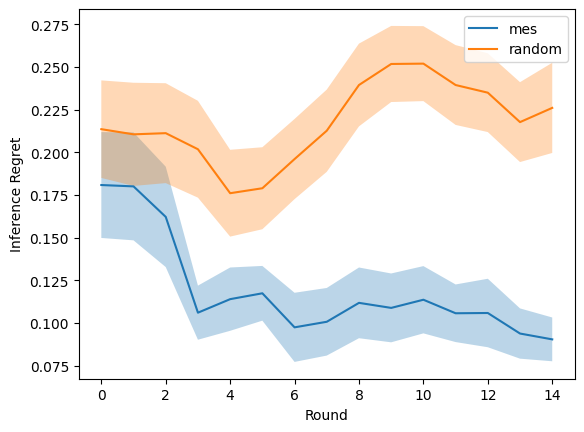

In [29]:
plot_regret(pos_best_dict)

In [30]:
z_rewards_dict['mes']

[tensor([0.1664, 0.3254, 0.2986, 0.3171, 0.2813, 0.3503, 0.2251, 0.3567, 0.3565,
         0.2142, 0.3424, 0.3478, 0.2468, 0.0797, 0.0947, 0.3529, 0.3445, 0.3610,
         0.3617, 0.3166, 0.2645, 0.1205, 0.3040, 0.1058, 0.1358, 0.3071, 0.2806,
         0.1869, 0.2286, 0.1744]),
 tensor([0.3288, 0.1394, 0.3441, 0.3581, 0.3512, 0.3537, 0.3025, 0.2427, 0.3436,
         0.3154, 0.3149, 0.3262, 0.1407, 0.3449, 0.3128, 0.2547, 0.3528, 0.1054,
         0.2724, 0.2428, 0.1046, 0.1190, 0.1480, 0.3497, 0.3564, 0.3338, 0.3143,
         0.3474, 0.1257, 0.1102]),
 tensor([0.3518, 0.3515, 0.2636, 0.3420, 0.3416, 0.3478, 0.2164, 0.2049, 0.3641,
         0.3406, 0.3637, 0.1500, 0.2700, 0.1724, 0.1420, 0.2986, 0.2831, 0.3474,
         0.3448, 0.3042, 0.3048, 0.3476, 0.3370, 0.1690, 0.3562, 0.2909, 0.3431,
         0.3491, 0.2412, 0.3556]),
 tensor([0.1498, 0.2146, 0.1712, 0.2925, 0.2860, 0.2271, 0.3612, 0.1180, 0.2898,
         0.1184, 0.1524, 0.2929, 0.3672, 0.2942, 0.1294, 0.2765, 0.1898, 0.3596,
    

[0.09026013 0.09669319 0.07755538 0.07006434 0.0925416  0.10251957
 0.10384093 0.12681322 0.0492048  0.12147804 0.09690575 0.0867314
 0.12053106 0.11593959 0.14368302 0.06964521 0.08113451 0.07085512
 0.09407011 0.1004537  0.12996113 0.11453247 0.11196665 0.15974732
 0.11093531 0.081837   0.10356672 0.11285756 0.0933232  0.13863218]
[0.09167747 0.09114771 0.07533529 0.07004941 0.08930508 0.0998681
 0.10546855 0.13124754 0.04841868 0.12492488 0.09393357 0.08789849
 0.12212269 0.12063456 0.13798246 0.09667435 0.09243576 0.10829587
 0.09803095 0.08243097 0.12502418 0.0854948  0.11867668 0.11267463
 0.10618784 0.12068689 0.10661368 0.09396749 0.09225269 0.07864104]


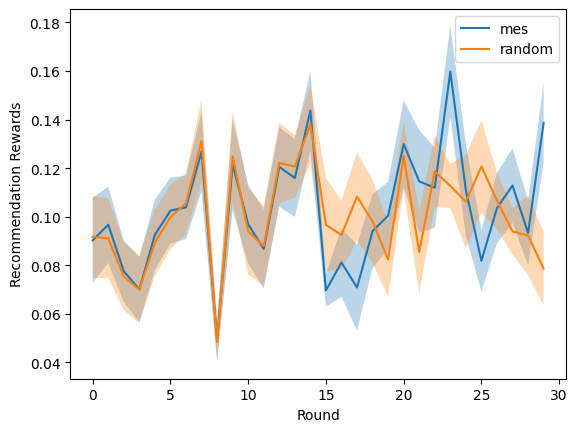

In [31]:
plot_regret(z_rewards_dict, title='Recommendation Rewards')

In [32]:
agent_mes.z_rewards

tensor([0.3652, 0.1904, 0.3340, 0.2394, 0.3153, 0.2799, 0.3058, 0.1222, 0.3460,
        0.3124, 0.1354, 0.3380, 0.3338, 0.2931, 0.2029, 0.2650, 0.2200, 0.3288,
        0.3187, 0.3475, 0.1307, 0.1193, 0.3525, 0.2644, 0.2915, 0.3188, 0.3453,
        0.1900, 0.3307, 0.2656])